In [1]:
# Cell 1: Imports & Paths
import os
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.amp import autocast, GradScaler
import matplotlib.pyplot as plt
import geopandas as gpd

BASE_DIR  = '/kaggle/input/datanasa/'
RAINF_DIR = os.path.join(BASE_DIR, 'visualization_outputUp', 'Rainf')
SOIL_DIR  = os.path.join(BASE_DIR, 'visualization_outputUp', 'SoilM_0_10cm')
QS_DIR    = os.path.join(BASE_DIR, 'visualization_outputUp', 'Qs')
QSB_DIR   = os.path.join(BASE_DIR, 'visualization_outputUp', 'Qsb')


In [2]:
# --- Cell 2 : Hyperparams et settings ---
T          = 6       # 6 pas historiques
DELTA      = 6       # horizon à +6 jours
BATCH_SIZE = 1       # gagné de la mémoire
LR         = 1e-4    # plus petit pour la stabilité
EPOCHS     = 50
PATIENCE   = 8
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Étendue CONUS
EXTENT    = [-125, -67, 25, 53]
THRESHOLD = 0.1  


In [3]:
# Cell 3: Common filenames & date list
folders = [RAINF_DIR, QS_DIR, QSB_DIR, SOIL_DIR]
sets_   = [set(os.listdir(d)) for d in folders]
common  = sorted(sets_[0].intersection(*sets_[1:]))
dates   = [fn[:-4] for fn in common]
print(f"Found {len(dates)} dates, e.g. {dates[:3]}")


Found 449 dates, e.g. ['A19790102', 'A19790103', 'A19790104']


In [4]:
# Cell 4: Reference size & downsample ×2
with Image.open(os.path.join(QS_DIR, common[0])).convert('L') as img:
    W0, H0 = img.size
W0 //= 2
H0 //= 2
print(f"Using size H0={H0}, W0={W0}")


Using size H0=475, W0=847


In [5]:
# Cell 5: Loader (grayscale, resizing, [0–1] normalization)
def load_gray(path):
    img = Image.open(path).convert('L')
    img = img.resize((W0, H0), Image.BILINEAR)
    return np.array(img, dtype=np.float32) / 255.0


In [6]:
# Cell 6: Dataset & DataLoader
class RunoffDataset(Dataset):
    def __init__(self, dates):
        self.dates = dates
    def __len__(self):
        return len(self.dates) - T - DELTA + 1
    def __getitem__(self, idx):
        window = self.dates[idx:idx+T]
        X_list = []
        for d in window:
            fn = f"{d}.png"
            X_list += [
                load_gray(os.path.join(RAINF_DIR, fn)),
                load_gray(os.path.join(QS_DIR,    fn)),
                load_gray(os.path.join(QSB_DIR,   fn)),
                load_gray(os.path.join(SOIL_DIR,  fn)),
            ]
        X = np.stack(X_list).reshape(T, 4, H0, W0)
        y_d = self.dates[idx + T + DELTA - 1]
        y   = load_gray(os.path.join(QS_DIR, f"{y_d}.png"))
        return (
            torch.tensor(X, dtype=torch.float32),
            torch.tensor(y, dtype=torch.float32).unsqueeze(0)
        )

ds = RunoffDataset(dates)
n_train = int(0.8 * len(ds))
train_ds, val_ds = torch.utils.data.random_split(ds, [n_train, len(ds)-n_train])
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=2)


In [7]:
# Cell 7: ConvLSTM model
class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        p = k // 2
        self.conv = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=p)
        self.hid_ch = hid_ch
    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)
        i, f, o, g = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next
    def init_hidden(self, B, H, W, device):
        return (
            torch.zeros(B, self.hid_ch, H, W, device=device),
            torch.zeros(B, self.hid_ch, H, W, device=device),
        )

class ConvLSTMForecaster(nn.Module):
    def __init__(self, in_ch=4, hid_ch=8, k=3, T=6):
        super().__init__()
        self.T       = T
        self.cell    = ConvLSTMCell(in_ch, hid_ch, k)
        self.conv_out= nn.Conv2d(hid_ch, 1, kernel_size=1)
    def forward(self, x):
        B, _, _, H, W = x.size()
        h, c = self.cell.init_hidden(B, H, W, x.device)
        for t in range(self.T):
            h, c = self.cell(x[:,t], h, c)
        return self.conv_out(h)

model     = ConvLSTMForecaster(in_ch=4, hid_ch=8, k=3, T=T).to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=5, verbose=True)
criterion = nn.MSELoss()
scaler    = GradScaler()


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [8]:
# Cellule 8 bis : MSE + deux “accuracies”
best_val = float('inf')
patience = PATIENCE
TOL = 0.1  # tolérance en kg·m⁻² pour accuracy_tol

for epoch in range(1, EPOCHS+1):
    # — TRAIN —
    model.train()
    train_loss = 0.0
    for X, Y in train_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        optimizer.zero_grad()
        pred = model(X)
        loss = criterion(pred, Y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_loss += loss.item() * X.size(0)
    train_loss /= len(train_loader.dataset)

    # — VALIDATION —
    model.eval()
    val_loss = 0.0
    correct_cls = 0
    correct_tol = 0
    total_pixels = 0

    with torch.no_grad():
        for X, Y in val_loader:
            X, Y = X.to(DEVICE), Y.to(DEVICE)
            pred = model(X)

            # 1) MSE
            val_loss += criterion(pred, Y).item() * X.size(0)

            # 2) Accuracy classification
            pred_bin = (pred > THRESHOLD).float()
            y_bin    = (Y    > THRESHOLD).float()
            correct_cls += (pred_bin == y_bin).sum().item()
            
            # 3) Accuracy tolérance
            abs_err = torch.abs(pred - Y)
            correct_tol += (abs_err < TOL).sum().item()

            total_pixels += Y.numel()

    val_loss /= len(val_loader.dataset)
    acc_cls = correct_cls / total_pixels
    acc_tol = correct_tol / total_pixels

    print((
        f"Epoch {epoch:02d} — "
        f"Train MSE: {train_loss:.4f}, "
        f"Val MSE: {val_loss:.4f}, "
        f"Acc_classif: {acc_cls*100:.2f}%, "
        f"Acc_tol (±{TOL}): {acc_tol*100:.2f}%"
    ))

    # — Scheduler & early stopping —
    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(model.state_dict(), 'best.pth')
        patience = PATIENCE
    else:
        patience -= 1
        if patience == 0:
            print("Early stopping.")
            break

    torch.cuda.empty_cache()


Epoch 01 — Train MSE: 0.0912, Val MSE: 0.0108, Acc_classif: 99.70%, Acc_tol (±0.1): 87.01%
Epoch 02 — Train MSE: 0.0096, Val MSE: 0.0083, Acc_classif: 99.70%, Acc_tol (±0.1): 89.19%
Epoch 03 — Train MSE: 0.0074, Val MSE: 0.0064, Acc_classif: 99.70%, Acc_tol (±0.1): 90.51%
Epoch 04 — Train MSE: 0.0057, Val MSE: 0.0050, Acc_classif: 99.70%, Acc_tol (±0.1): 91.40%
Epoch 05 — Train MSE: 0.0046, Val MSE: 0.0041, Acc_classif: 99.70%, Acc_tol (±0.1): 92.19%
Epoch 06 — Train MSE: 0.0036, Val MSE: 0.0031, Acc_classif: 99.70%, Acc_tol (±0.1): 94.06%
Epoch 07 — Train MSE: 0.0027, Val MSE: 0.0023, Acc_classif: 99.70%, Acc_tol (±0.1): 95.51%
Epoch 08 — Train MSE: 0.0020, Val MSE: 0.0017, Acc_classif: 99.72%, Acc_tol (±0.1): 96.44%
Epoch 09 — Train MSE: 0.0016, Val MSE: 0.0013, Acc_classif: 99.74%, Acc_tol (±0.1): 97.27%
Epoch 10 — Train MSE: 0.0013, Val MSE: 0.0011, Acc_classif: 99.76%, Acc_tol (±0.1): 97.80%
Epoch 11 — Train MSE: 0.0011, Val MSE: 0.0009, Acc_classif: 99.77%, Acc_tol (±0.1): 98.22%

In [9]:
# Cell X : Évaluation “régression” (R² et MAE) sur le jeu de validation
import torch
import numpy as np

model.eval()
ss_res = 0.0   # somme des carrés des résidus
ss_tot = 0.0   # somme totale des carrés
mae_sum = 0.0  # somme des erreurs absolues
n_pixels = 0

with torch.no_grad():
    # on accumule toutes les vraies valeurs et prédictions pour calculer R²
    for X, Y in val_loader:
        X, Y = X.to(DEVICE), Y.to(DEVICE)
        pred = model(X)

        # on met en vecteur 1D
        y_true = Y.view(-1).cpu().numpy()
        y_pred = pred.view(-1).cpu().numpy()

        # pour R²
        ss_res  += np.sum((y_true - y_pred) ** 2)
        # on met à jour la moyenne globale partielle
        # (on calculera ss_tot après avoir la moyenne totale)
        # mais on peut faire en deux passes ou, plus simply, calculer y_true_mean avant la boucle :
        #   y_all = np.concatenate([...]) ; y_mean = y_all.mean()
        # ici, on fait une seconde boucle :
        mae_sum += np.sum(np.abs(y_true - y_pred))
        n_pixels += y_true.size

# calcul de la moyenne des y de val pour ss_tot
# (on peut la stocker en mémoire car val_loader est généralement < quelques millions de pixels)
all_y = []
with torch.no_grad():
    for _, Y in val_loader:
        all_y.append(Y.view(-1).cpu().numpy())
all_y = np.concatenate(all_y)
y_mean = all_y.mean()
ss_tot = np.sum((all_y - y_mean) ** 2)

r2  = 1 - (ss_res / ss_tot)
mae = mae_sum / n_pixels

print(f"R² (coefficient de détermination) : {r2:.4f}")
print(f"MAE (erreur absolue moyenne)       : {mae:.4f}")


R² (coefficient de détermination) : 0.9903
MAE (erreur absolue moyenne)       : 0.0046


In [3]:
# Cellule 9 : sauvegarde finale du modèle
import torch

MODEL_SAVE_PATH = 'model_final.pth'
torch.save(model.state_dict(), MODEL_SAVE_PATH)
print(f"Modèle sauvegardé dans {MODEL_SAVE_PATH}")


Modèle sauvegardé dans model_final.pth


In [11]:
!ls -lh

total 32K
-rw-r--r-- 1 root root 16K Apr 27 12:11 best.pth
-rw-r--r-- 1 root root 16K Apr 27 12:12 model_final.pth


In [12]:
%%bash
cat > model.py << 'EOF'
import torch
import torch.nn as nn

class ConvLSTMCell(nn.Module):
    def __init__(self, in_ch, hid_ch, k):
        super().__init__()
        p = k // 2
        self.conv   = nn.Conv2d(in_ch + hid_ch, 4 * hid_ch, k, padding=p)
        self.hid_ch = hid_ch

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates    = self.conv(combined)
        i, f, o, g = gates.chunk(4, dim=1)
        i = torch.sigmoid(i)
        f = torch.sigmoid(f)
        o = torch.sigmoid(o)
        g = torch.tanh(g)
        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next

    def init_hidden(self, batch_size, height, width, device):
        h = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        c = torch.zeros(batch_size, self.hid_ch, height, width, device=device)
        return h, c

class ConvLSTMForecaster(nn.Module):
    def __init__(self, in_ch, hid_ch, k, T):
        super().__init__()
        self.T        = T
        self.cell     = ConvLSTMCell(in_ch, hid_ch, k)
        self.conv_out = nn.Conv2d(hid_ch, 1, kernel_size=1)

    def forward(self, x):
        B, _, _, H, W = x.size()
        h, c = self.cell.init_hidden(B, H, W, x.device)
        for t in range(self.T):
            h, c = self.cell(x[:, t], h, c)
        return self.conv_out(h)
EOF


In [13]:
# Vérification rapide
import os
print("Fichier model.py présent :", os.path.isfile("model.py"))

# Tester l'import
from model import ConvLSTMCell, ConvLSTMForecaster
print("Import OK :", ConvLSTMCell, ConvLSTMForecaster)


Fichier model.py présent : True
Import OK : <class 'model.ConvLSTMCell'> <class 'model.ConvLSTMForecaster'>


Dataset size: 438


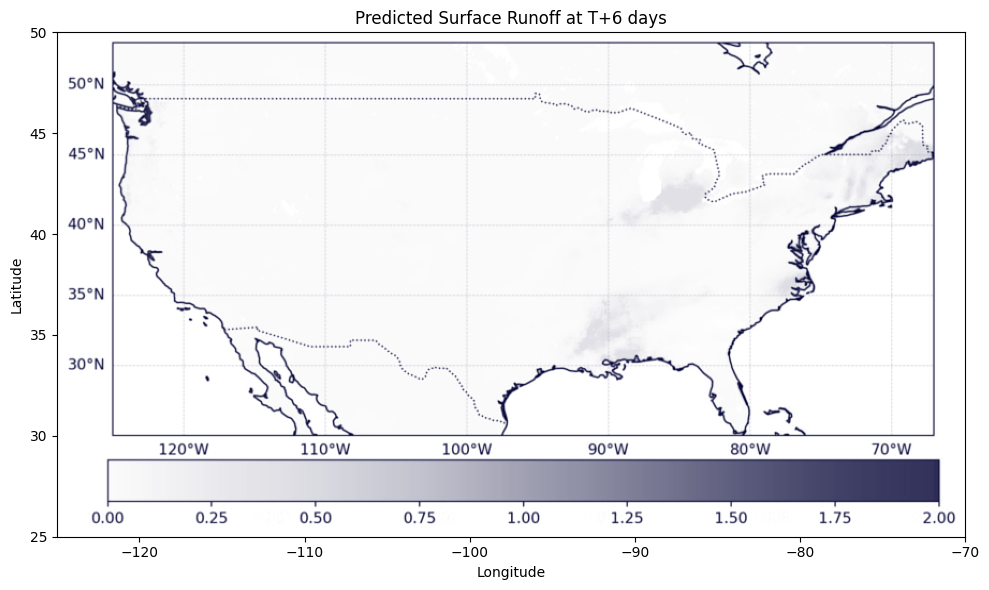

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from model import ConvLSTMForecaster

# --- 1. Préparation du device & paths ---
DEVICE     = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = 'model_final.pth'
EXTENT     = (-125, -70, 25, 50)

# --- 2. Instanciation du modèle ---
model = ConvLSTMForecaster(in_ch=4, hid_ch=8, k=3, T=T).to(DEVICE).eval()

# --- 3. Chargement des poids (sécurisé) ---
state = torch.load(MODEL_PATH, map_location=DEVICE, weights_only=True)
model.load_state_dict(state)

# --- 4. Vérification du dataset & sélection d’un index valide ---
print("Dataset size:", len(ds))
idx = len(ds) - 1    # dernier échantillon valide
# ou idx = 0, ou un autre entier entre 0 et len(ds)-1
X0, _ = ds[idx]

# --- 5. Préparation de la donnée & prédiction ---
X0_batch = X0.unsqueeze(0).to(DEVICE)
with torch.no_grad():
    pred_norm = model(X0_batch).cpu().squeeze().numpy()

# --- 6. Conversion & flip ---
pred_qs      = pred_norm * 2.0
data_to_plot = np.flipud(pred_qs)

# --- 7. Tracé —
plt.style.use('default')
fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
ax.set_facecolor('white')

# Définition d’une colormap allant du beige nude très clair (#f5f5dc) à un bleu foncé
colors = ['#000033', '#ffffff'] 
dark_blue_cmap = LinearSegmentedColormap.from_list('dark_blue', colors)

im = ax.imshow(
    data_to_plot,
    origin='lower',
    extent=EXTENT,
    vmin=0, vmax=2,
    cmap=dark_blue_cmap,
    aspect='auto'
)

ax.set_xlim(EXTENT[0], EXTENT[1])
ax.set_ylim(EXTENT[2], EXTENT[3])
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Predicted Surface Runoff at T+6 days')

plt.tight_layout()
plt.show()
